In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil import parser

In [51]:
# Define the path to the folder containing the CSV files
folder_path = 'pendle_data'

# Initialize an empty DataFrame for the combined data
pt_df = pd.DataFrame()
yt_df = pd.DataFrame()
imp_apy_df = pd.DataFrame()

def get_maturity(month_year: pd.Series):
    # Define a mapping from month abbreviations to numbers
    month_map = {
        'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04',
        'may': '05', 'jun': '06', 'jul': '07', 'aug': '08',
        'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
    }
    
    # Extract the month and year parts from the input
    month = month_year.str[:3].str.lower().map(month_map)
    year = '20' + month_year.str[-2:]
    
    # Combine month and year into MM-YYYY format
    return month + '-' + year

# Function to format the data based on the token type
def format_data(df: pd.DataFrame, token_type: str):
    if token_type in ['pt', 'yt']:
        df['token'] = df['source_file'].str[3:-7]
        df = df.loc[:, ['time', 'volume', 'value', 'maturity', 'token']].copy()
        df.rename(columns={'value': f'{token_type}_price'}, inplace=True)
    elif token_type == 'imp_apy':
        df['token'] = df['source_file'].str[8:-7]
        df = df.loc[:, ['time', 'underlyingApy', 'impliedApy', 'maturity', 'token']].copy()
    return df

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        temp_df = pd.read_csv(file_path)
        temp_df['source_file'] = filename[:-4]
        temp_df['maturity'] = get_maturity(temp_df['source_file'].str[-6:])

        if filename.startswith('pt'):
            temp_df = format_data(temp_df, 'pt')
            pt_df = pd.concat([pt_df, temp_df], ignore_index=True)
        elif filename.startswith('yt'):
            temp_df = format_data(temp_df, 'yt')
            yt_df = pd.concat([yt_df, temp_df], ignore_index=True)
        elif filename.startswith('imp_apy'):
            temp_df = format_data(temp_df, 'imp_apy')
            imp_apy_df = pd.concat([imp_apy_df, temp_df], ignore_index=True)
        else:
            print(f'Unknown file type: {filename}')
            continue

# Merge the pt, yt, and imp_apy DataFrames on time, maturity, and token
token_price_df = pd.merge(pt_df, yt_df, on=['time', 'maturity', 'token', 'volume']) # volume is always the same for pt and yt
final_df = pd.merge(token_price_df, imp_apy_df, on=['time', 'maturity', 'token'])
final_df['time'] = pd.to_datetime(final_df['time'], format='%a %b %d %Y %H:%M:%S GMT%z (Eastern European Summer Time)')
final_df['time'] = final_df['time'].dt.tz_convert('UTC')

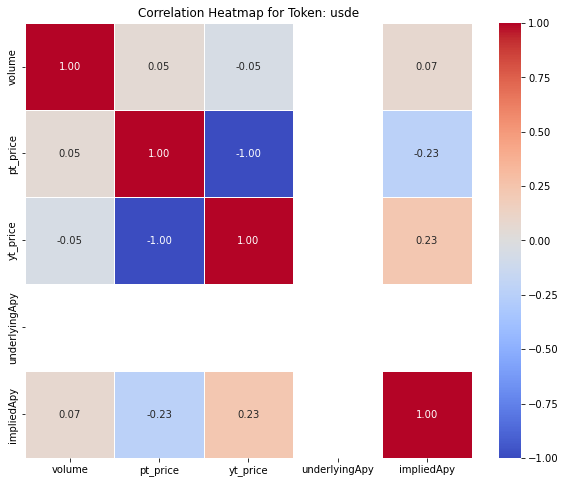

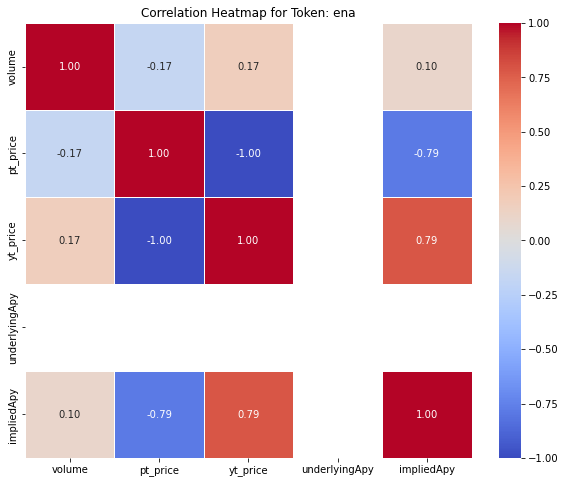

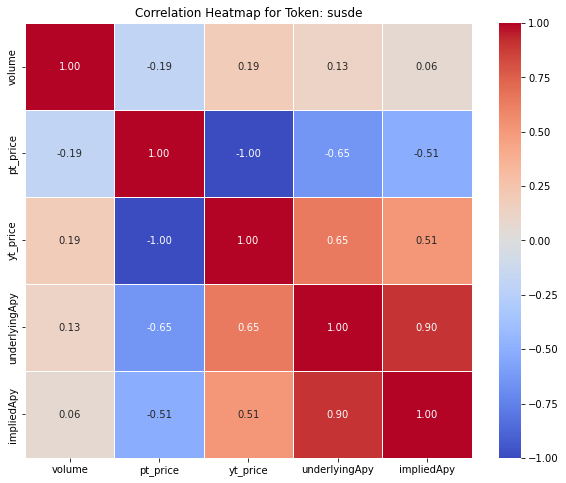

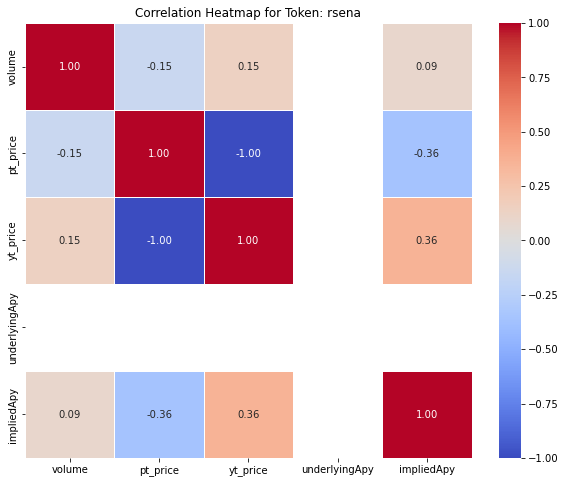

In [52]:
# List of unique tokens
unique_tokens = final_df['token'].unique()

# Function to create correlation matrix and heatmap
def create_correlation_heatmap(df: pd.DataFrame, token: str):
    corr_matrix = df.corr()
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title(f'Correlation Heatmap for Token: {token}')
    plt.show()

# Loop through each unique token
for token in unique_tokens:
    token_df = final_df[final_df['token'] == token]
    create_correlation_heatmap(token_df, token)


In [53]:
"""
Groupy by token amd maturity, get mean implied apy per day, sum volume
"""

daily_df = final_df.groupby(['token', 'maturity', final_df['time']]).agg({'volume': 'sum', 'impliedApy': 'mean', 'yt_price': 'last', 'pt_price': 'last'}).reset_index()
#daily_df.to_csv('data/pendle_token_data.csv', index=False)

<AxesSubplot:>

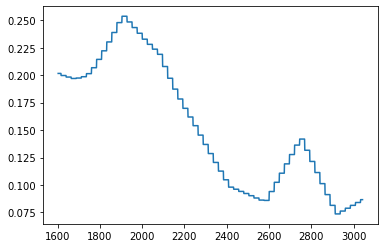

In [54]:
final_df[(final_df['token'] == 'susde') & (final_df['maturity'] == '09-2024')]['underlyingApy'].plot()


### Long Yield Strategy
Previously it was noticed that eth returns granger cause impliedApy on ena. Here we further investigate wether this relationship can be used to predict impliedApy on pendle ena tokens, and thus utilized in a long yield strategy.

In [70]:
external_data = pd.read_csv('data/ena_1h_data.csv')
external_data['time'] = pd.to_datetime(external_data['Datetime'])

# merge 
combined_df = pd.merge(final_df, external_data.drop(columns='Datetime'), on='time').sort_values('time')
combined_df = combined_df[combined_df['token'] == 'susde']

# investigate wether ETH_Returns granger cause susde implied apy
from statsmodels.tsa.stattools import grangercausalitytests

# Take first difference of impliedApy to stationarize it
combined_df['impliedApy'] = combined_df['impliedApy'].diff()
combined_df = combined_df.set_index('time')
combined_df = combined_df.dropna()

grangercausalitytests(combined_df[['impliedApy', 'underlyingApy']], maxlag=10)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9888  , df_denom=2149, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9887  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9887  , df=1
parameter F test:         F=0.0002  , p=0.9888  , df_denom=2149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2274  , p=0.7966  , df_denom=2146, df_num=2
ssr based chi2 test:   chi2=0.4558  , p=0.7962  , df=2
likelihood ratio test: chi2=0.4557  , p=0.7962  , df=2
parameter F test:         F=0.2274  , p=0.7966  , df_denom=2146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3935  , p=0.7577  , df_denom=2143, df_num=3
ssr based chi2 test:   chi2=1.1843  , p=0.7568  , df=3
likelihood ratio test: chi2=1.1840  , p=0.7569  , df=3
parameter F test:         F=0.3935  , p=0.7577  , df_denom=2143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5783  , p=0.

{1: ({'ssr_ftest': (0.00019874771688023002, 0.9887532712675052, 2149.0, 1),
   'ssr_chi2test': (0.0001990251683230596, 0.9887441147827202, 1),
   'lrtest': (0.00019902515850844793, 0.9887441150602349, 1),
   'params_ftest': (0.0001987477169407811, 0.9887532712540049, 2149.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.22736592853349372, 0.796648407208275, 2146.0, 2),
   'ssr_chi2test': (0.4557913441524184, 0.7962073221593464, 2),
   'lrtest': (0.4557430604709225, 0.7962265443017484, 2),
   'params_ftest': (0.22736592853336224, 0.7966484072084649, 2146.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.39347748600369203, 0.7577130829323199, 2143.0, 3),
   'ssr_chi2test': (1.184288280319092, 0.756775044977133, 3),
   'lrtest': (1.1839622282495839, 0.7568533457982, 3),
   'params_ftest': (0.39347748600349775, 0.7577130829325486, 2143.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
     

In [71]:
grangercausalitytests(combined_df[['impliedApy', 'ETH_Returns']], maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0749  , p=0.7844  , df_denom=2149, df_num=1
ssr based chi2 test:   chi2=0.0750  , p=0.7842  , df=1
likelihood ratio test: chi2=0.0750  , p=0.7842  , df=1
parameter F test:         F=0.0749  , p=0.7844  , df_denom=2149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0851  , p=0.9184  , df_denom=2146, df_num=2
ssr based chi2 test:   chi2=0.1706  , p=0.9182  , df=2
likelihood ratio test: chi2=0.1706  , p=0.9182  , df=2
parameter F test:         F=0.0851  , p=0.9184  , df_denom=2146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0878  , p=0.9668  , df_denom=2143, df_num=3
ssr based chi2 test:   chi2=0.2641  , p=0.9666  , df=3
likelihood ratio test: chi2=0.2641  , p=0.9666  , df=3
parameter F test:         F=0.0878  , p=0.9668  , df_denom=2143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0476  , p=0.

{1: ({'ssr_ftest': (0.07485582151069867, 0.7844199251687448, 2149.0, 1),
   'ssr_chi2test': (0.07496032009819614, 0.7842469128012219, 1),
   'lrtest': (0.07495901458787557, 0.7842487451125434, 1),
   'params_ftest': (0.07485582151059296, 0.7844199251687448, 2149.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.08512519654561404, 0.9184003979855352, 2146.0, 2),
   'ssr_chi2test': (0.17064706222704176, 0.9182151651655526, 2),
   'lrtest': (0.17064029354514787, 0.9182182727239927, 2),
   'params_ftest': (0.08512519654552812, 0.9184003979855352, 2146.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.08776050127849587, 0.9667714063219203, 2143.0, 3),
   'ssr_chi2test': (0.2641414994149782, 0.9666251040054435, 3),
   'lrtest': (0.26412527499269345, 0.9666280189823695, 3),
   'params_ftest': (0.08776050127851649, 0.9667714063219203, 2143.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
      